In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install --user imblearn

In [4]:
df = pd.read_csv('kyphosis.csv')

In [5]:
df.head()

,Kyphosis,Age,Number,Start
0,absent,71,3,5
1,absent,158,3,14
2,present,128,4,5
3,absent,2,5,1
4,absent,1,4,15


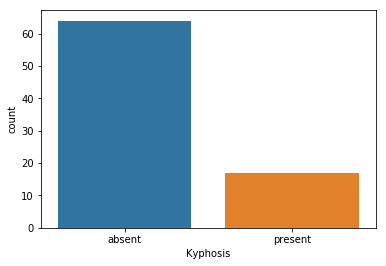

In [6]:
sns.countplot('Kyphosis', data=df)

In [7]:
perc_present = np.around(len(df[df['Kyphosis'] == 'present'])/len(df) * 100, decimals=2)
perc_absent =  np.around(len(df[df['Kyphosis'] == 'absent'])/len(df) * 100, decimals=2)
print("Present class has {}% instances and absent class has {}% instances".format(perc_present, perc_absent))
print("Total dataset size:", len(df))

Present class has 20.99% instances and absent class has 79.01% instances
Total dataset size: 81


The dataset is unbalanced. Since the dataset is small, we will oversample the scarce class.

In [8]:
df = pd.get_dummies(df, drop_first=True)
df.head(5)

,Age,Number,Start,Kyphosis_present
0,71,3,5,0
1,158,3,14,0
2,128,4,5,1
3,2,5,1,0
4,1,4,15,0


In [9]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [10]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_res, y_res = oversampler.fit_resample(X,y)
print("Negative samples:", len(y_res[y_res==0]), "Positive samples:", len(y_res[y_res==1]), "after oversampling")

Using TensorFlow backend.


Negative samples: 64 Positive samples: 64 after oversampling


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3)

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(df.iloc[:,:-1].values)

In [14]:
df_new = df.copy()

In [15]:
df_new['col1'] = X_train_pca[:,0]
df_new['col2'] = X_train_pca[:,1]

In [16]:
df_new.head()

,Age,Number,Start,Kyphosis_present,col1,col2
0,71,3,5,0,-12.685466,6.194657
1,158,3,14,0,74.357543,-2.272141
2,128,4,5,1,44.313375,6.627497
3,2,5,1,0,-81.705154,10.114691
4,1,4,15,0,-82.636133,-3.878245


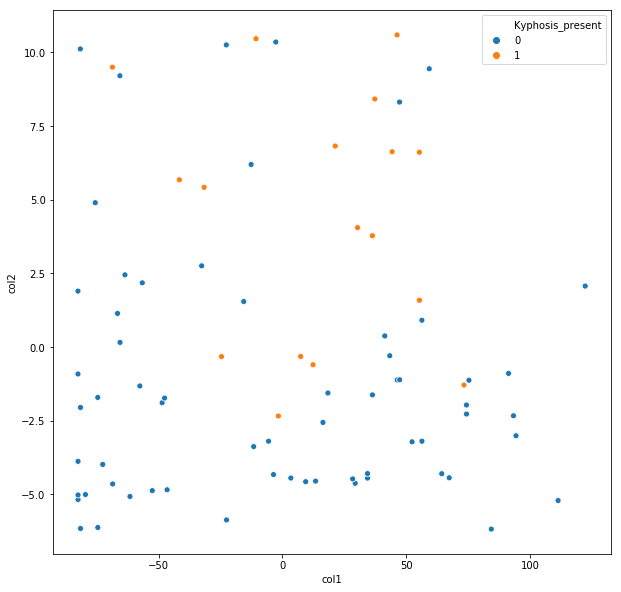

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot('col1', 'col2', hue='Kyphosis_present', data=df_new, ax=ax)

The data is not linearly separable, so linear models might perform bad in this data.

In [18]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=0)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Decision tree accuracy:", accuracy_score(y_test, pred))

Decision tree accuracy: 0.9743589743589743


In [20]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.96      1.00      0.98        24

    accuracy                           0.97        39
   macro avg       0.98      0.97      0.97        39
weighted avg       0.98      0.97      0.97        39



In [21]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

In [22]:
print("Accuracy of logistic regression:",accuracy_score(y_test, pred))

Accuracy of logistic regression: 0.6923076923076923


In [23]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.58      0.73      0.65        15
           1       0.80      0.67      0.73        24

    accuracy                           0.69        39
   macro avg       0.69      0.70      0.69        39
weighted avg       0.71      0.69      0.70        39



In [24]:
from sklearn.svm import SVC
classifier = SVC(kernel='rbf')
classifier.fit(X_train,y_train)
pred = classifier.predict(X_test)
print("SVM accuracy score:", accuracy_score(y_test, pred))

SVM accuracy score: 0.7692307692307693


In [25]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.80      0.83      0.82        24

    accuracy                           0.77        39
   macro avg       0.76      0.75      0.75        39
weighted avg       0.77      0.77      0.77        39



In [26]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, criterion='entropy')
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
print("Accuracy of random forest: ",accuracy_score(y_test, pred))

Accuracy of random forest:  0.9743589743589743


In [27]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.96      1.00      0.98        24

    accuracy                           0.97        39
   macro avg       0.98      0.97      0.97        39
weighted avg       0.98      0.97      0.97        39



**USING RandomizedSearchCV TO FIND OPTIMAL HYPERPARAMETERS FOR DECISION TREE CLASSIFIER**

In [28]:
params = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random']
}

In [32]:
from sklearn.model_selection import RandomizedSearchCV
classifier = DecisionTreeClassifier()
random_search = RandomizedSearchCV(classifier, params, verbose=1)
search = random_search.fit(X_res,y_res)
search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [30]:
from sklearn.model_selection import cross_val_score
classifier = search.best_estimator_
print("Accuracy achieved:", np.mean(cross_val_score(classifier,X_res,y_res, cv=10)))

Accuracy achieved: 0.9455128205128205


In [31]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.92      0.96        26

    accuracy                           0.95        39
   macro avg       0.93      0.96      0.94        39
weighted avg       0.96      0.95      0.95        39

